# Menor caminho visitando lugares turísticos

Variação do problema do caixeiro viajante, o problema consiste em determinar a ordem de visita dos pontos turísticos, de maneira que se minimize a distância percorrida.

Deve-se a partir um ponto qualquer X, visitar todos os outros pontos uma vez e retornar a X.

## Sumário

- [Preliminares](#Preliminares)
- [Pré-processamento](#Pré-processamento)
    - [Obtenção de latitude e longitude](#Obtenção-de-latitude-e-longitude)
    - [Limpeza de dados](#Limpeza-de-dados)
- [Implementando o algoritmo genético](#Implementando-o-algoritmo-genético)
    - [Obter matriz de distâncias](#Obter-matriz-de-distâncias)
    - [Função fitness](#Função-fitness)
    - [Criação de rotas](#Criação-de-rotas)
    - [População inicial](#População-inicial)
    - [Classificando os indivíduos](#Classificando-os-indivíduos)
    - [Seleção dos pais](#Seleção-dos-pais)
    - [Cruzamento](#Cruzamento)
    - [Mutação](#Mutação)
    - [Próxima geração](#Próxima-geração)
- [Executando o algoritmo e analisando os resultados](#Executando-o-algoritmo-e-analisando-os-resultados)
- [Conclusão](#Conclusão)

## Preliminares
Importação de dependências

### Coisas de quem usa Google Collab

In [ ]:
#from google.colab import files
#uploaded = files.upload()

### Dependências

In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import seaborn as sns
import math
import random

import requests
from urllib.parse import urlencode
import json
import os

## Pré-processamento

Obtenção de latitude e longitude dos pontos e limpeza de dados.

In [2]:
sns.set(rc = {'figure.figsize':(16, 8)})

df = pd.read_csv('./Dataset/Sao_Paulo_State_of_Sao_Paulo.csv', delimiter=",", encoding = 'cp1252')

df.head()

,Ref,Name,Category,Address,Days,Hours,Number of Reviews,Rating,Excellent,Very Good,Average,Poor,Terrible,Certified
0,/Attraction_Review-g303631-d311966-Reviews-Par...,Parque Ibirapuera,Natureza e parques,"Av. Pedro Álvares Cabral | Vila Mariana, São P...",Dom - Sáb,05:00 - 00:00,36.534,"4,5",65%,29%,4%,1%,1%,True
1,/Attraction_Review-g303631-d550339-Reviews-Pau...,Avenida Paulista,Pontos turísticos e de interesse,"Av. Paulista, São Paulo, Estado de São Paulo 0...",NaN,NaN,29.104,"4,5",62%,29%,7%,1%,1%,True
2,/Attraction_Review-g303631-d4377562-Reviews-Co...,Arena Corinthians,Pontos turísticos e de interesse,"Avenida Miguel Ignacio Curi, 111 | Itaquera, S...",Dom - Sáb,09:30 - 16:30,4.423,"4,5",81%,14%,3%,1%,1%,True
3,/Attraction_Review-g303631-d2349915-Reviews-Al...,Allianz Parque,Pontos turísticos e de interesse,Avenida Francisco Matarazzo 1705 | Água Branca...,Dom - Sáb,10:00 - 17:00,5.138,"4,5",74%,21%,3%,1%,1%,True
4,/Attraction_Review-g303631-d1407969-Reviews-Mu...,Museu do Futebol,Museus,"Praça Charles Miller, S/N | Estádio do Pacaemb...",Ter - Dom,09:00 - 17:00,9.404,"4,5",61%,32%,5%,1%,1%,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644 entries, 0 to 643
Data columns (total 14 columns):
Ref                  644 non-null object
Name                 644 non-null object
Category             629 non-null object
Address              644 non-null object
Days                 177 non-null object
Hours                177 non-null object
Number of Reviews    644 non-null float64
Rating               644 non-null object
Excellent            644 non-null object
Very Good            644 non-null object
Average              644 non-null object
Poor                 644 non-null object
Terrible             644 non-null object
Certified            644 non-null bool
dtypes: bool(1), float64(1), object(12)
memory usage: 66.2+ KB


É possível ver que algumas instâncias possuem dados ausentes.

### Obtenção de latitude e longitude
Utiliza-se a API do TomTom para obter a latitude e longitude dos pontos turísticos.

In [4]:
def fowardGeocoding(query, country, key):
    response = requests.get("https://api.tomtom.com/search/2/geocode/" + query[1: ] + 
                            ".json?limit=1&countrySet=" + country + 
                            "&key=" + key)

    return response

In [5]:
def codeLocation(addresses, country):
    lat = []
    lon = []
    for address in addresses:
        if address != "N/A":
            query = urlencode({"": address})
            try:
                result = fowardGeocoding(query, country, "0sU5MUNhItpxLVRhCiSoUvyNEDU0OvCK").text
                loads = json.loads(result)
                c = loads['results'][0]['position']
                lat.append(c['lat'])
                lon.append(c['lon'])

            except: # Não foi possível encontrar a latitude e longitude do ponto
                lat.append(0)
                lon.append(0)
            
    return lat, lon

As duas funções acima transformarão os dados contidos em Address em latitude e longitude. Instâncias com valores ausentes para Address serão descartadas:

In [6]:
df.dropna(subset = ['Address'], inplace = True)
df.reset_index(inplace = True)
df.drop(columns = ['index'], inplace = True)
print("Sobraram", len(df), "instâncias!")

Sobraram 644 instâncias!


Enfim, faz-se a conversão:

In [7]:
latitudes, longitudes = codeLocation(df['Address'], 'BR')

In [8]:
geocodes_df = pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes})

df = df.join(geocodes_df)

df.head()

,Ref,Name,Category,Address,Days,Hours,Number of Reviews,Rating,Excellent,Very Good,Average,Poor,Terrible,Certified,Latitude,Longitude
0,/Attraction_Review-g303631-d311966-Reviews-Par...,Parque Ibirapuera,Natureza e parques,"Av. Pedro Álvares Cabral | Vila Mariana, São P...",Dom - Sáb,05:00 - 00:00,36.534,"4,5",65%,29%,4%,1%,1%,True,-23.59161,-46.65056
1,/Attraction_Review-g303631-d550339-Reviews-Pau...,Avenida Paulista,Pontos turísticos e de interesse,"Av. Paulista, São Paulo, Estado de São Paulo 0...",NaN,NaN,29.104,"4,5",62%,29%,7%,1%,1%,True,-23.55731,-46.66108
2,/Attraction_Review-g303631-d4377562-Reviews-Co...,Arena Corinthians,Pontos turísticos e de interesse,"Avenida Miguel Ignacio Curi, 111 | Itaquera, S...",Dom - Sáb,09:30 - 16:30,4.423,"4,5",81%,14%,3%,1%,1%,True,-23.54623,-46.47236
3,/Attraction_Review-g303631-d2349915-Reviews-Al...,Allianz Parque,Pontos turísticos e de interesse,Avenida Francisco Matarazzo 1705 | Água Branca...,Dom - Sáb,10:00 - 17:00,5.138,"4,5",74%,21%,3%,1%,1%,True,-23.52581,-46.67978
4,/Attraction_Review-g303631-d1407969-Reviews-Mu...,Museu do Futebol,Museus,"Praça Charles Miller, S/N | Estádio do Pacaemb...",Ter - Dom,09:00 - 17:00,9.404,"4,5",61%,32%,5%,1%,1%,True,-23.54495,-46.66580


Lembrar de salvar a base de dados para evitar estourar a cota diária de uso da API:

In [9]:
df.to_csv('SP_Coded.csv', index = False, encoding = 'cp1252')

### Limpeza de dados

A geocodificação gerou algumas instâncias com latitude e longitude 0, e também resultou em valores errados para outras, a decisão tomada para estas é de simplesmente removê-las.

In [36]:
df = pd.read_csv('JPA_Coded.csv', delimiter=",", encoding = 'cp1252')

In [37]:
df = df[df['Latitude'] != 0] # Manter quem possui latitude diferente de 0
df.reset_index(inplace = True)
df = df[df['Longitude'] != 0] # Manter quem possui longitude diferente de 0
df.reset_index(inplace = True)
df.drop(columns = ['index'], inplace = True)
print("Sobraram", len(df), "instâncias!")

Sobraram 117 instâncias!


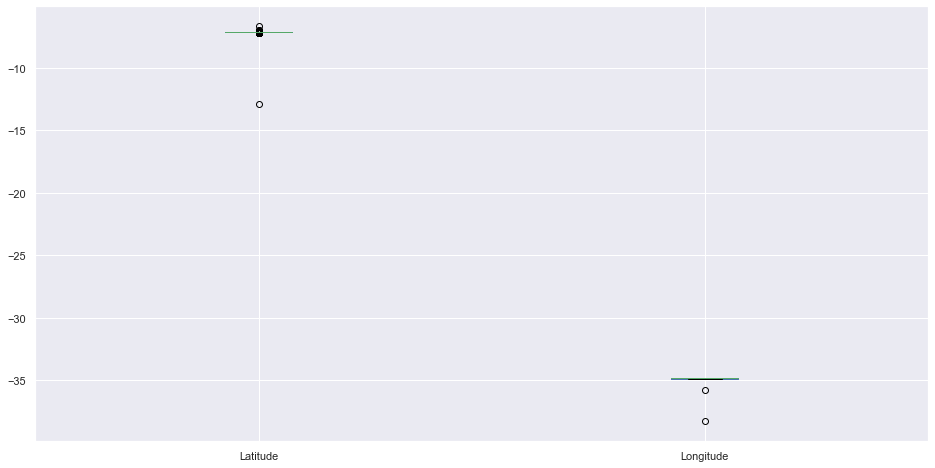

In [38]:
df.boxplot(column = ['Latitude', 'Longitude'])

Como é de se esperar os pontos turísticos de uma mesma cidade terão uma pequena variação entre a latitude e longitude destes, resultando que pontos mais distantes serão identificados como outliers, contudo, eles podem de fato serem um ponto turístico ou simplesmente, terem sido erroneamente geocodificados (Por exemplo: Um ponto do Crato, CE, ser codificado para um lugar no Maranhão). 

A decisão tomada quanto a isso será limitar as latitudes e longitudes em um intervalo, pré-definido, tendo em consideração os seguintes valores para a latitude e longitude das cidades (Obtidos por meio de uma pesquisa no Google):

- Crato: 7.2300° S, 39.4123° W
- São Paulo: 23.5505° S, 46.6333° W
- João Pessoa: 7.1195° S, 34.8450° W
- Varginha: 21.5561° S, 45.4369° W
- Uberlândia: 18.9128° S, 48.2755° W
- Hallstatt, Aústria: 47.5622° N, 13.6493° E


In [39]:
lat_lon_dict = { "Crato": [-7.23, -39.4123],
                 "SP": [-23.5505, -46.6333],
                 "JPA": [-7.1195, -34.845],
                 "Varginha": [-21.5561, -45.4369],
                 "Uberlandia": [-18.9128, -48.2755],
                 "Hallstatt": [47.5622, 13.6493]
}

In [40]:
def dropOutliersByZScore(df, column, threshold = 3):

    df2 = df[(np.abs(stats.zscore(df[column])) < threshold)].copy()

    df2.reset_index(inplace = True)
    df2.drop(columns = ['index'], inplace = True)
    
    return df2

def dropOutliersByRange(df, column, minValue, maxValue):

    df2 = df[abs(df[column]) > maxValue].copy()
    df2.reset_index(inplace = True)
    df2.drop(columns = ['index'], inplace = True)
    
    df3 = df2[abs(df2[column]) < minValue].copy()
    df3.reset_index(inplace = True)
    
    df3.drop(columns = ['index'], inplace = True)
    
    return df3

Temos que:

Latitude: 1 deg = 110,574 km

Longitude: 1 deg = 111,320 * cos(latitude) km

Serão aceitos pontos que se encontrem a até 0.5 graus em termos absolutos da mediana.

In [41]:
df = dropOutliersByRange(df, 'Latitude', abs(df['Latitude'].median() - 0.5), abs(df['Latitude'].median() + 0.5))
df = dropOutliersByRange(df, 'Longitude', abs(df['Longitude'].median() - 0.5), abs(df['Longitude'].median() + 0.5))
print("Sobraram", len(df), "instâncias!")

Sobraram 115 instâncias!


Ainda é possível que existam instâncias com valores duplicados:

In [42]:
df[df.duplicated(subset = ['Latitude', 'Longitude'], keep = False)]

,level_0,Ref,Name,Category,Address,Days,Hours,Number of Reviews,Rating,Excellent,Very Good,Average,Poor,Terrible,Certified,Latitude,Longitude
0,0,/Attraction_Review-g303428-d2342247-Reviews-Ta...,Praia de Tambaú,Atividades ao ar livre,"Av. Alm. Tamandare - Tambau, João Pessoa, Para...",NaN,NaN,5.597,"4,0",43%,41%,14%,1%,1%,True,-7.11466,-34.82261
2,2,/Attraction_Review-g303428-d2342321-Reviews-Pi...,Picãozinho - Embarcação Pirata,Atividades ao ar livre,"| Ilha Picãozinho no Oceano, João Pessoa, Par...",NaN,NaN,2.498,"4,5",55%,30%,12%,2%,1%,True,-7.14016,-34.89785
3,3,/Attraction_Review-g303428-d4702338-Reviews-Ig...,Igreja São Francisco,Pontos turísticos e de interesse,"Ladeira São Francisco, Centro, João Pessoa, Pa...",Dom,09:00 - 14:00,2.756,"4,5",59%,32%,7%,1%,1%,True,-7.11447,-34.88470
4,4,/Attraction_Review-g303428-d2342253-Reviews-Be...,Praia do Bessa,Atividades ao ar livre,"João Pessoa, Paraíba, Brasil",Seg - Sáb,08:00 - 18:00,1.790,"4,0",43%,40%,15%,1%,1%,True,-7.11525,-34.86105
6,6,/Attraction_Review-g303428-d4586364-Reviews-Ce...,Centro Histórico de João Pessoa,Pontos turísticos e de interesse,"Centro Historico Joao Pessoa, João Pessoa, Par...",NaN,NaN,1.630,"4,0",41%,35%,19%,4%,1%,True,-7.11525,-34.86105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,103,/Attraction_Review-g303428-d4376618-Reviews-Mo...,Museu de Arte Popular Mostra Brasil,Museus especializados,"Praca Sao Francisco s/n | Centro, João Pessoa,...",NaN,NaN,10.000,"4,0",30%,40%,30%,0%,0%,False,-7.11447,-34.88470
102,104,/Attraction_Review-g303428-d4376612-Reviews-Bi...,Big House of Tiles,Museus especializados,"Rua Conselheiro Henrique 159 | Centro, João Pe...",NaN,NaN,13.000,"3,5",7%,38%,48%,7%,0%,False,-7.11644,-34.88317
106,108,/Attraction_Review-g303428-d2342218-Reviews-Mu...,Museu Fotográfico Walfredo Rodrigues,Museus especializados,"Ladeira de São Francisco S/N | Centro, João Pe...",NaN,NaN,10.000,"3,0",10%,20%,40%,30%,0%,False,-7.11447,-34.88470
107,109,/Attraction_Review-g303428-d4127654-Reviews-UF...,UFPB - Teatro Lampião,Teatros,"Campus Universitario-Campus I, João Pessoa, Pa...",NaN,NaN,13.000,"3,5",15%,40%,23%,15%,7%,False,-7.18194,-34.82663


Por exemplo, os teatros da UFPB, apesar de serem dois pontos diferentes, foram codificados em um mesmo lugar, contudo, é esperado, uma vez que o endereço destes é o do local que o contém (a UFPB). Nenhuma ação adicional será tomada quanto a isso.

## Implementando o algoritmo genético

### Obter matriz de distâncias

Necessário para obter o custo de cada rota.

In [43]:
df.reset_index(inplace = True) # adicionar uma coluna de indices

In [44]:
def createDistancesMatrix(lat, lon):
    if len(lat) != len(lon):
        return None
    
    dimension = len(lat)
    matrix = np.zeros((dimension, dimension))

    RRR = 6378.388
    for i in range(dimension):
        for j in range(dimension):
            dlon = math.radians(lon[j]) - math.radians(lon[i])
            dlat = math.radians(lat[j]) - math.radians(lat[i])

            a = math.sin(dlat / 2) ** 2 + math.cos(math.radians(lat[i])) * math.cos(math.radians(lat[j])) * math.sin(dlon / 2) ** 2
            c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
            
            matrix[i][j] = RRR * c
    
    return matrix

In [45]:
matrix = createDistancesMatrix(df['Latitude'], df['Longitude'])

In [46]:
def scatter(x, y, title = None):
    fig, ax = plt.subplots()
    ax.scatter(x, y, c='orange')
    #line = mlines.Line2D([0, 1], [0, 1], color='black')
    #transform = ax.transAxes
    #line.set_transform(transform)
    #ax.add_line(line)
    plt.xlabel("Lat")
    plt.ylabel("Lon")
    if title != None:
        plt.title(title)
    plt.show()

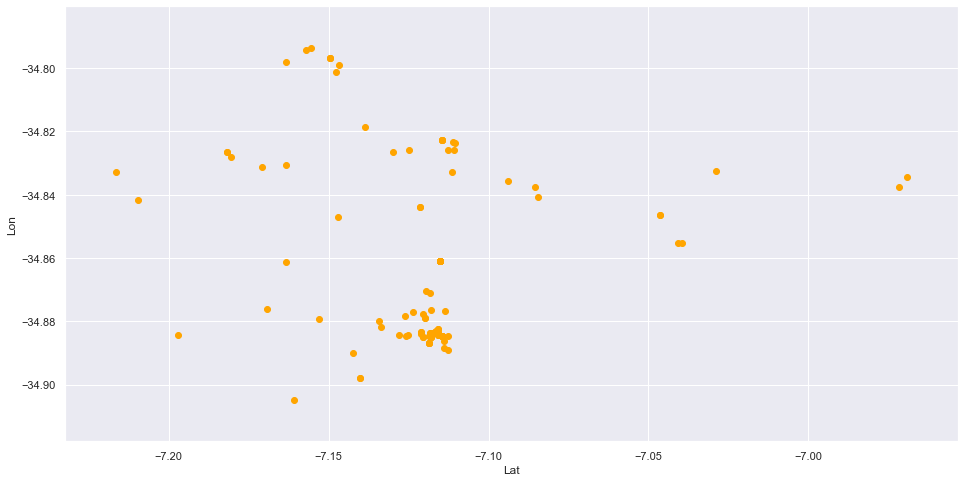

In [47]:
scatter(df['Latitude'], df['Longitude'])

### Função fitness
Será o inverso da distância da rota, valores menores para a função objetivo (minimizar custo da rota) resultarão em um fitness maior.

In [48]:
def getDistance(route, matrix):
    distance = 0
    for i in range(0, len(route) - 1):
        distance += matrix[route[i]][route[i + 1]]
        
    distance += matrix[route[len(route) - 1]][route[0]]
    
    return distance

def getFitness(cost):
    if cost != 0:
        return 1 / cost
    else:
        return 1

### Criação de rotas
Geração aleatória, cada rota conterá uma sequência aleatória de visitação.

In [49]:
def createRoute():
    return random.sample(list(df['index']), len(df))

### População inicial
A população será criada chamando a inicialização aleatória de rotas.

In [50]:
def createPopulation(size):
    population = []
    
    for i in range(size):
        route_id = i
        newRoute = createRoute()
        distance = getDistance(newRoute, matrix)
        fitness = getFitness(distance)
        
        population.append({"ID": route_id, "Route": newRoute, "Distance": distance, "Fitness": fitness})
    
    return population

### Classificando os indivíduos
Definir a classificação de cada rota, rotas com valores maiores de fitness estarão no início da lista de rotas.

In [51]:
def rank(population):
    return sorted(population, key = lambda x : x['Fitness'], reverse = True)

### Seleção dos pais
Só os mais fortes sobrevivem, será utilizada a roleta ~russa~ para escolher os indivíduos que prosseguirão para o cruzamento, os ```eliteSize``` indivíduos com maior fitness são automaticamente escolhidos, enquanto que, o resto será escolhido de maneira aleatória, contudo, com chance maior para aqueles com um maior valor de fitness.

In [52]:
def selection(population, eliteSize):
    selected = []
    
    candidates = pd.DataFrame([list(map(pop.get, ['ID', 'Fitness'])) for pop in population], columns = ['ID', 'Fitness'])
    candidates['cum_sum'] = candidates['Fitness'].cumsum()
    ## calcular o fitness relativo de cada individuo
    candidates['cum_pct'] = 100 * candidates['cum_sum'] / candidates['Fitness'].sum()
    
    for i in range(eliteSize): # Elitismo
        selected.append(population[i])
        
    for i in range(len(population) - eliteSize):
        pick = 100 * random.random()
        for i in range(len(population)):
            if pick <= candidates.iat[i, 3]:
                selected.append(population[i])
                break
                
    return selected

### Cruzamento
Geração de novos indivíduos a partir do cruzamento, uma faixa ```[min(geneA, geneB)..max(geneA, geneB)]``` do parente A será inserido no inicio do filho gerado, enquanto que aqueles pontos não contemplados pela faixa serão inseridos no filho conforme a ordem de visitação do parente B.

In [53]:
def breed(a, b):
    childA = []
    childB = []
    
    geneA = int(random.random() * len(a))
    geneB = int(random.random() * len(b))
    
    start = min(geneA, geneB)
    end = max(geneA, geneB)
    
    for i in range(start, end):
        childA.append(a[i])
        
    childB = [point for point in b if point not in childA]
    
    return (childA + childB)

A próxima geração conterá ```eliteSize``` indivíduos, justamente aqueles com o maior fitness, que serão copiados da geração atual, enquanto que o resto da população será criada a partir do cruzamento entre dois pais aleatórios do chamado pool de procriação.

In [54]:
def createOffspring(population, eliteSize):
    childs = []
    pool = random.sample(population, len(population))
    
    for i in range(eliteSize):
        childs.append(pool[i])
        
    for i in range(0, len(population) - eliteSize):
        route_id = len(childs)
        newRoute = breed(pool[i]['Route'], pool[len(population) - i - 1]['Route'])
        distance = getDistance(newRoute, matrix)
        fitness = getFitness(distance)
        childs.append({"ID": route_id, "Route": newRoute, "Distance": distance, "Fitness": fitness})
        
    return childs

### Mutação
Troca a ordem de visitação de dois pontos, qualquer indivíduo da população pode sofrer uma mutação, a frequência desta dependerá do parâmetro rate.

In [55]:
def mutation(route, rate):
    for swapped in range(len(route)):
        if(random.random() < rate):
            toSwap = int(random.random() * len(route))
            
            aux = route[toSwap]
            route[toSwap] = route[swapped]
            route[swapped] = aux
            
    return route

In [56]:
def mutatePopulation(population, rate):
    mutated = []
    
    for i in range(len(population)):
        route_id = len(mutated)
        newRoute = mutation(population[i]['Route'], rate)
        distance = getDistance(newRoute, matrix)
        fitness = getFitness(distance)
        mutated.append({"ID": route_id, "Route": newRoute, "Distance": distance, "Fitness": fitness})
        
    return mutated

### Próxima geração

Classificar a população, selecionar aqueles que irão se cruzar, criar a nova geração e mutação.

In [57]:
def nextGeneration(currentGeneration, eliteSize, mutationRate):
    ranked = rank(currentGeneration)
    selected = selection(ranked, eliteSize)
    child = createOffspring(selected, eliteSize)
    
    return mutatePopulation(child, mutationRate)

### Juntando tudo
O critério de parada para o algoritmo será generations, isto é, o algoritmo permanecerá executando enquanto que a o número da geração atual for menor que generations.

In [58]:
def geneticAlgorithm(popSize, eliteSize, mutationRate, generations, showResults = False):
    pops = createPopulation(popSize)
    results = []
    
    if showResults is True:
        best = rank(pops)[0]['Distance']
        print("Initial distance: " + str(best))
        results.append({"Generation": 0, "Distance": best})
        
    for i in range(generations):
        pops = nextGeneration(pops, eliteSize, mutationRate)
        if showResults is True:
            best = rank(pops)[0]['Distance']
            results.append({"Generation": i + 1, "Distance": best})
            
    if showResults is True:
        best = rank(pops)[0]['Distance']
        print("Final distance: " + str(best))
        results.append({"Generation": generations + 1, "Distance": best})
        
    return (rank(pops), results)

## Executando o algoritmo e analisando os resultados

Executando com um tamanho de população igual a 100, elitismo igual a 25, chance de mutação igual a 0,01% e 500 gerações.

Initial distance: 573.6047917085448
Final distance: 354.8370063439344


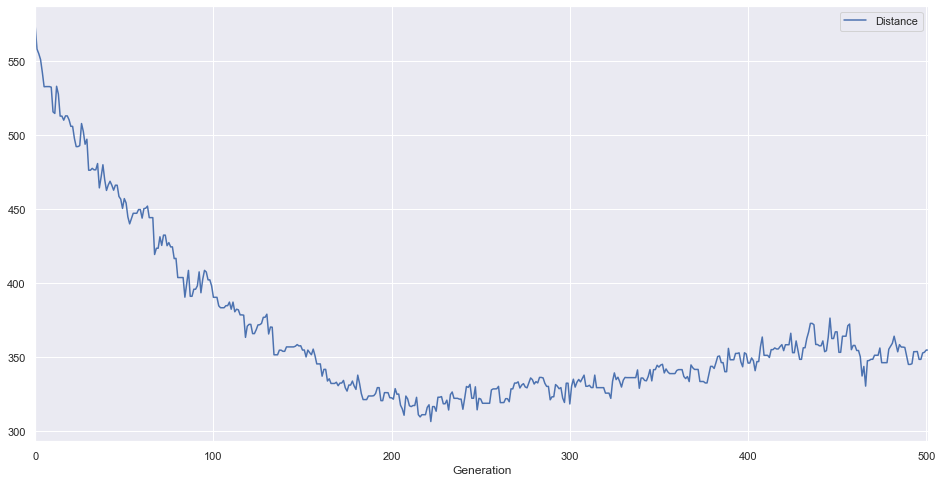

In [59]:
f, results = geneticAlgorithm(100, 25, 0.0001, 500, showResults = True)
pd.DataFrame(results).plot.line(x = "Generation",
                                y = "Distance")

Até a geração de aproximadamente 200 o gráfico do custo da melhor solução naquela geração cai, sendo a queda maior nas primeiras gerações.

Contudo, após esse ponto, é possível observar que o custo da melhor solução acabou por aumentar.  

Além disso, é possível ver alguns saltos consideráveis (em termos absolutos) entre gerações.

É possível que uma mutação tenha acarretado na qual um indivíduo com uma boa solução perto da geração 200 tenha se transformado em uma má solução, além de que os cruzamentos não conseguiram gerar indivíduos melhores, além da geração 200. 

Desta vez, o algoritmo visitou Chernobyl e aumentou a chance de mutação de um indivíduo para 10%:

Initial distance: 593.4804307238585
Final distance: 547.3770509220778


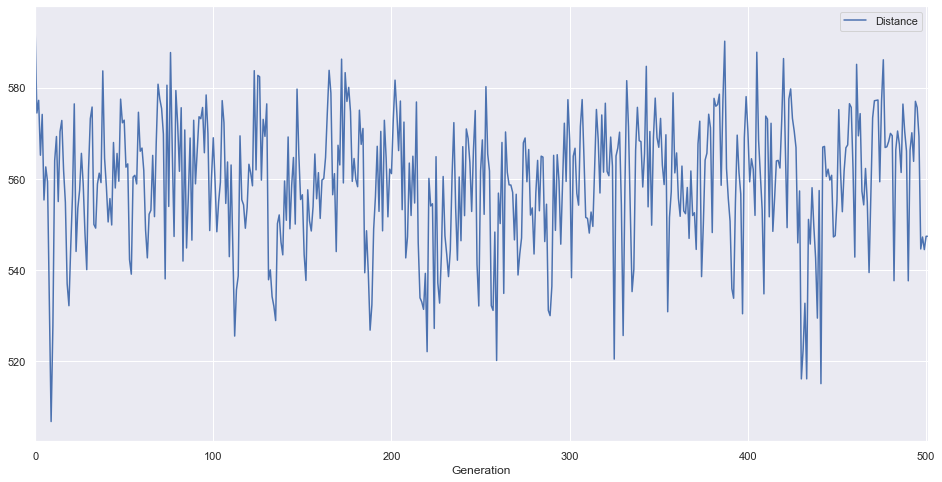

In [60]:
f, results = geneticAlgorithm(100, 25, 0.1, 500, showResults = True)
pd.DataFrame(results).plot.line(x = "Generation",
                                y = "Distance")

Nesta execução, não é possível ver uma convergência do gráfico de custos por cada geração.

As mutações frequentes acabaram por não permitir que indivíduos com boas soluções mantivessem essas soluções por muitas gerações.

Como resultado, o valor da solução vai depender muito da sorte, sendo mais viável contar com esta pra algo mais útil (e.g. loteria)

O algoritmo decidiu virar mais elitista, e manteve os 50 melhores indivíduos da população:

Initial distance: 581.5060129040551
Final distance: 226.29391198414226


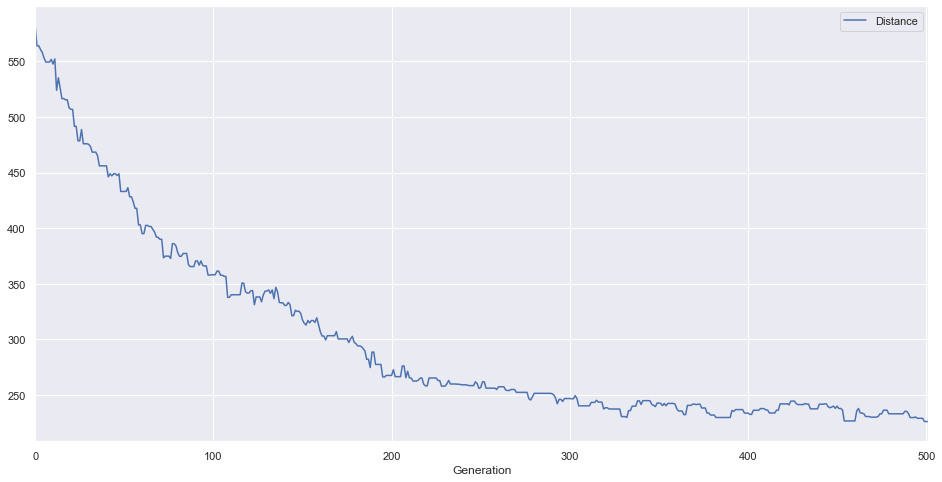

In [61]:
f, results = geneticAlgorithm(100, 50, 0.0001, 500, showResults = True)
pd.DataFrame(results).plot.line(x = "Generation",
                                y = "Distance")

A curva do gráfico é bastante semelhante àquela observada na primeira execução, contudo depois da geração 200 os valores do melhor indivíduo não aumentam.

É possível ver que após a geração de aproximadamente 200, o custo da solução converge lentamente para cerca de 230 Km.

Além disso, também há uma menor diferença entre o custo de cada melhor solução entre gerações consecutivas.

Aumentar o elitismo acarretou em mais indivíduos com boas soluções serem mantidos em gerações futuras, assim diminuindo a chance de haverem más soluções na população, sejam estas geradas pelo cruzamento ou mutação.

## Conclusão

A partir do nosso trabalho, podemos adicionar a funcionalidade de poder informar a classificação dos pontos, segundo o TripAdvisor, ao usuário.

Para o projeto ter uma melhor usabilidade poderia ser transformado em uma aplicação web ou móvel. Nesta aplicação o usuário irá escolher os pontos turísticos da cidade que quer visitar, e será mostrado a  melhor rota para visitar todos os pontos.  

Ainda, poderia ser feita uma IA para escolher um conjunto de pontos turísticos e utilizar o algoritmo para encontrar o menor caminho entre eles.